Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

/Users/kdalwani/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases

  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 3.706680
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.631908
Minibatch accuracy: 43.8%
Validation accuracy: 63.6%
Minibatch loss at step 100: 1.073402
Minibatch accuracy: 68.8%
Validation accuracy: 71.3%
Minibatch loss at step 150: 0.456939
Minibatch accuracy: 87.5%
Validation accuracy: 74.6%
Minibatch loss at step 200: 0.462690
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 250: 0.808182
Minibatch accuracy: 75.0%
Validation accuracy: 76.3%
Minibatch loss at step 300: 0.533314
Minibatch accuracy: 81.2%
Validation accuracy: 80.2%
Minibatch loss at step 350: 0.529298
Minibatch accuracy: 75.0%
Validation accuracy: 80.1%
Minibatch loss at step 400: 0.599159
Minibatch accuracy: 87.5%
Validation accuracy: 80.8%
Minibatch loss at step 450: 0.672836
Minibatch accuracy: 93.8%
Validation accuracy: 80.9%
Minibatch loss at 

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

## Add Max Pool

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases


  # Training computation.
  logits = model_with_max_pool(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model_with_max_pool(tf_test_dataset))

In [9]:
num_steps = 2500

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 3.726452
Minibatch accuracy: 18.8%
Validation accuracy: 10.0%
Minibatch loss at step 200: 0.524313
Minibatch accuracy: 81.2%
Validation accuracy: 77.1%
Minibatch loss at step 400: 0.429896
Minibatch accuracy: 87.5%
Validation accuracy: 82.0%
Minibatch loss at step 600: 1.004696
Minibatch accuracy: 75.0%
Validation accuracy: 82.3%
Minibatch loss at step 800: 0.569929
Minibatch accuracy: 81.2%
Validation accuracy: 84.4%
Minibatch loss at step 1000: 0.434699
Minibatch accuracy: 87.5%
Validation accuracy: 85.3%
Minibatch loss at step 1200: 0.450290
Minibatch accuracy: 81.2%
Validation accuracy: 85.6%
Minibatch loss at step 1400: 0.171078
Minibatch accuracy: 100.0%
Validation accuracy: 85.7%
Minibatch loss at step 1600: 0.653498
Minibatch accuracy: 75.0%
Validation accuracy: 86.3%
Minibatch loss at step 1800: 0.698956
Minibatch accuracy: 75.0%
Validation accuracy: 86.6%
Minibatch 

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

## Add dropout

## Add exponential decay learning rate

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph_with_pool_dropout = tf.Graph()

with graph_with_pool_dropout.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")

  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))

In [12]:
num_steps = 2500

learning_rate_start = 0.1
dropout = 0.7
with tf.Session(graph=graph_with_pool_dropout) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2.611063
Minibatch accuracy: 18.8%
Validation accuracy: 10.7%
Minibatch loss at step 500: 0.362622
Minibatch accuracy: 93.8%
Validation accuracy: 83.3%
Minibatch loss at step 1000: 0.437526
Minibatch accuracy: 75.0%
Validation accuracy: 84.9%
Minibatch loss at step 1500: 0.352199
Minibatch accuracy: 93.8%
Validation accuracy: 86.3%
Minibatch loss at step 2000: 0.244539
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Test accuracy: 92.4%


## Change loss function by add weights to loss

In [38]:
batch_size = 16
patch_size = 5
num_hidden = 64
beta = 0.01
graph_with_pool_dropout = tf.Graph()
depth = 16
with graph_with_pool_dropout.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1) )
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1), validate_shape=False)
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer4_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))

In [41]:
num_steps = 2500
step_hist = []
train_accs = []
valid_accs = []

depths = [16, 32]
learning_rate_start = 0.05
dropout = 0.7

with tf.Session(graph=graph_with_pool_dropout) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 500) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 5.385172
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 500: 1.896718
Minibatch accuracy: 81.2%
Validation accuracy: 79.8%
Minibatch loss at step 1000: 1.566156
Minibatch accuracy: 81.2%
Validation accuracy: 83.6%
Minibatch loss at step 1500: 1.216644
Minibatch accuracy: 93.8%
Validation accuracy: 85.4%
Minibatch loss at step 2000: 0.784536
Minibatch accuracy: 93.8%
Validation accuracy: 84.6%
Test with loss in weights accuracy: 92.1%


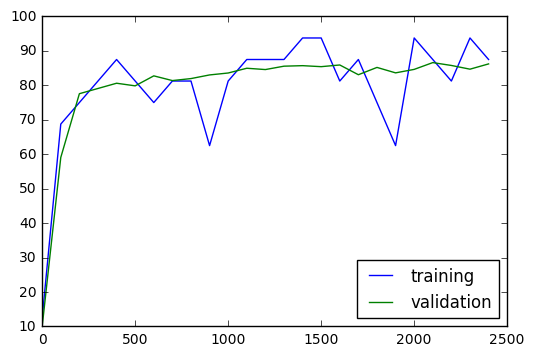

In [42]:

plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()


## depth = 32

In [43]:
batch_size = 16
patch_size = 5
num_hidden = 64
beta = 0.01
graph_with_pool_dropout = tf.Graph()
depth = 32
with graph_with_pool_dropout.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1) )
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1), validate_shape=False)
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer4_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))

num_steps = 2500
step_hist = []
train_accs = []
valid_accs = []

learning_rate_start = 0.05
dropout = 0.7

with tf.Session(graph=graph_with_pool_dropout) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 800) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 11.909672
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 500: 3.473585
Minibatch accuracy: 81.2%
Validation accuracy: 81.7%
Minibatch loss at step 1000: 2.624509
Minibatch accuracy: 75.0%
Validation accuracy: 84.5%
Minibatch loss at step 1500: 1.906041
Minibatch accuracy: 87.5%
Validation accuracy: 85.9%
Minibatch loss at step 2000: 1.225946
Minibatch accuracy: 93.8%
Validation accuracy: 85.9%
Test with loss in weights accuracy: 92.0%


## Two FC after Convs.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 9.981892
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 800: 3.104237
Minibatch accuracy: 81.2%
Validation accuracy: 83.3%
Minibatch loss at step 1600: 1.934252
Minibatch accuracy: 75.0%
Validation accuracy: 83.9%
Minibatch loss at step 2400: 1.211746
Minibatch accuracy: 93.8%
Validation accuracy: 84.6%
Test with loss in weights accuracy: 91.5%


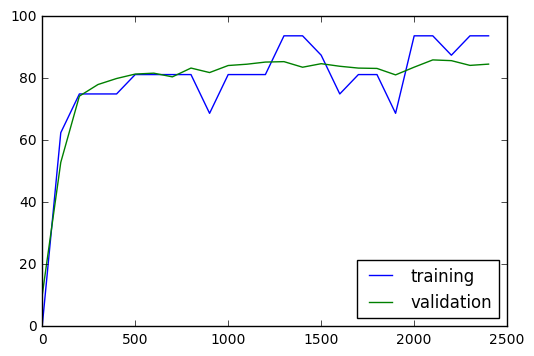

In [46]:
batch_size = 16
patch_size = 5
num_hidden = 64
# num_hidden = 2048
num_hidden2 = 64

beta = 0.01
graph_with_pool_dropout_two_fc = tf.Graph()
depth = 32
with graph_with_pool_dropout_two_fc.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1) )
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  # FC 1   
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=0.1), validate_shape=False)
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    
  # FC 2   
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=0.1), validate_shape=False)
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    fc_1 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(fc_1, layer5_weights) + layer5_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer4_weights) + beta * tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))

num_steps = 2500
step_hist = []
train_accs = []
valid_accs = []

learning_rate_start = 0.05
dropout = 0.7

with tf.Session(graph=graph_with_pool_dropout_two_fc) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 800) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 205.977310
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 400: 165.642639
Minibatch accuracy: 81.2%
Validation accuracy: 69.1%
Minibatch loss at step 800: 164.540375
Minibatch accuracy: 68.8%
Validation accuracy: 78.0%
Minibatch loss at step 1200: 163.719727
Minibatch accuracy: 68.8%
Validation accuracy: 73.8%
Minibatch loss at step 1600: 162.664948
Minibatch accuracy: 75.0%
Validation accuracy: 77.3%
Minibatch loss at step 2000: 160.812027
Minibatch accuracy: 87.5%
Validation accuracy: 78.4%
Minibatch loss at step 2400: 160.373184
Minibatch accuracy: 81.2%
Validation accuracy: 77.5%
Test with loss in weights accuracy: 85.8%


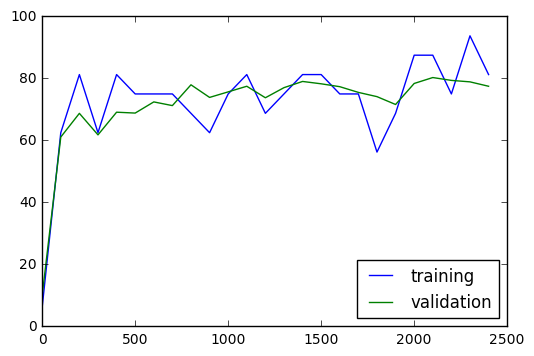

In [48]:
batch_size = 16
patch_size = 5
num_hidden = 2048
num_hidden2 = 512

beta = 0.01
graph_with_pool_dropout_two_fc = tf.Graph()
depth = 32
with graph_with_pool_dropout_two_fc.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1) )
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  # FC 1   
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=0.1), validate_shape=False)
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    
  # FC 2   
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=0.1), validate_shape=False)
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    fc_1 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(fc_1, layer5_weights) + layer5_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer4_weights) + beta * tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))

num_steps = 2500
step_hist = []
train_accs = []
valid_accs = []

learning_rate_start = 0.001
dropout = 0.7

with tf.Session(graph=graph_with_pool_dropout_two_fc) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 400) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()


## with xavier_initializer

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 6.474710
Minibatch accuracy: 10.9%
Validation accuracy: 10.0%
Minibatch loss at step 400: 2.062950
Minibatch accuracy: 84.4%
Validation accuracy: 80.0%
Minibatch loss at step 800: 1.668416
Minibatch accuracy: 85.9%
Validation accuracy: 82.4%
Minibatch loss at step 1200: 1.273158
Minibatch accuracy: 84.4%
Validation accuracy: 84.8%
Minibatch loss at step 1600: 1.361681
Minibatch accuracy: 79.7%
Validation accuracy: 82.7%
Minibatch loss at step 2000: 1.148736
Minibatch accuracy: 79.7%
Validation accuracy: 85.4%
Minibatch loss at step 2400: 1.213638
Minibatch accuracy: 76.6%
Validation accuracy: 86.2%
Minibatch loss at step 2800: 0.789122
Minibatch accuracy: 84.4%
Validation accuracy: 86.0%
Minibatch loss at step 3200: 0.586818
Minibatch accuracy: 90.6%
Validation accuracy: 87.1%
Minibatch loss at step 3600: 0.618128
Minibatch accuracy: 89.1%
Validation accuracy: 86.9%
Minibatch

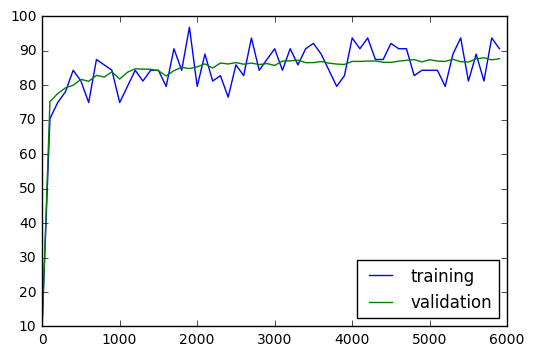

In [58]:
batch_size = 64
patch_size = 5
num_hidden = 128
num_hidden2 = 64

beta = 0.01
graph_with_pool_dropout_two_fc = tf.Graph()
depth = 32
with graph_with_pool_dropout_two_fc.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  layer1_weights = tf.get_variable('conv1_weights', shape=[patch_size, patch_size, num_channels, depth], 
                               initializer=tf.contrib.layers.xavier_initializer())
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.get_variable('conv2_weights', shape=
      [patch_size, patch_size, depth, depth], initializer=tf.contrib.layers.xavier_initializer())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.get_variable('conv3_weights', shape=
      [image_size // 4 * image_size // 4 * depth, num_hidden], initializer=tf.contrib.layers.xavier_initializer())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  # FC 1   
  layer4_weights = tf.get_variable('fc1_weights',shape=[num_hidden, num_hidden2], initializer=tf.contrib.layers.xavier_initializer())
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    
  # FC 2   
  layer5_weights = tf.get_variable('fc2_weights', shape=
      [num_hidden2, num_labels], initializer=tf.contrib.layers.xavier_initializer())
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    fc_1 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(fc_1, layer5_weights) + layer5_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer4_weights) + beta * tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))


num_steps = 6000
step_hist = []
train_accs = []
valid_accs = []

learning_rate_start = 0.05
dropout = 0.7

with tf.Session(graph=graph_with_pool_dropout_two_fc) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 400) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()


# with more depth = 64

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 8.213844
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 800: 2.142655
Minibatch accuracy: 82.8%
Validation accuracy: 84.6%
Minibatch loss at step 1600: 1.663320
Minibatch accuracy: 79.7%
Validation accuracy: 84.3%
Minibatch loss at step 2400: 1.290773
Minibatch accuracy: 75.0%
Validation accuracy: 87.2%
Minibatch loss at step 3200: 0.683324
Minibatch accuracy: 93.8%
Validation accuracy: 88.0%
Minibatch loss at step 4000: 0.482977
Minibatch accuracy: 95.3%
Validation accuracy: 87.6%
Minibatch loss at step 4800: 0.763647
Minibatch accuracy: 85.9%
Validation accuracy: 88.3%
Minibatch loss at step 5600: 0.646369
Minibatch accuracy: 85.9%
Validation accuracy: 88.2%
Test with loss in weights accuracy: 93.1%


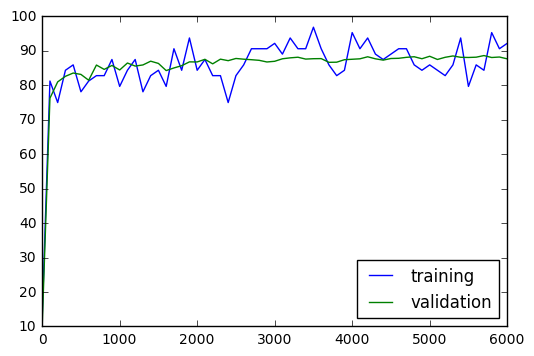

In [64]:
batch_size = 64
patch_size = 5
num_hidden = 128
num_hidden2 = 64
depth = 64

beta = 0.01
graph_with_pool_dropout_two_fc = tf.Graph()
with graph_with_pool_dropout_two_fc.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  layer1_weights = tf.get_variable('conv1_weights', shape=[patch_size, patch_size, num_channels, depth], 
                               initializer=tf.contrib.layers.xavier_initializer())
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.get_variable('conv2_weights', shape=
      [patch_size, patch_size, depth, depth], initializer=tf.contrib.layers.xavier_initializer())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.get_variable('conv3_weights', shape=
      [image_size // 4 * image_size // 4 * depth, num_hidden], initializer=tf.contrib.layers.xavier_initializer())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  # FC 1   
  layer4_weights = tf.get_variable('fc1_weights',shape=[num_hidden, num_hidden2], initializer=tf.contrib.layers.xavier_initializer())
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    
  # FC 2   
  layer5_weights = tf.get_variable('fc2_weights', shape=
      [num_hidden2, num_labels], initializer=tf.contrib.layers.xavier_initializer())
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    fc_1 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(fc_1, layer5_weights) + layer5_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer4_weights) + beta * tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))


num_steps = 6001
step_hist = []
train_accs = []
valid_accs = []

learning_rate_start = 0.05
dropout = 0.7

with tf.Session(graph=graph_with_pool_dropout_two_fc) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 800) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()


## 3 Conv, layer, 3 FC layers. 

image_size:28, num_channels:1
image_size
4

--------------------------------
--------------------------------
--------------------------------
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 8.495698
Minibatch accuracy: 4.7%
Validation accuracy: 10.0%
Minibatch loss at step 800: 1.879009
Minibatch accuracy: 78.1%
Validation accuracy: 81.4%
Minibatch loss at step 1600: 1.498662
Minibatch accuracy: 78.1%
Validation accuracy: 79.0%
Minibatch loss at step 2400: 1.247155
Minibatch accuracy: 81.2%
Validation accuracy: 85.5%
Minibatch loss at step 3200: 0.675592
Minibatch accuracy: 92.2%
Validation accuracy: 86.8%
Minibatch loss at step 4000: 0.509567
Minibatch accuracy: 93.8%
Validation accuracy: 86.6%
Minibatch loss at step 4800: 0.879111
Minibatch accuracy: 78.1%
Validation accuracy: 87.5%
Minibatch loss at step 5600: 0.608046
Minibatch accuracy: 87.5%
Validation accuracy: 86.6%
Minibatch loss at step 6400: 0.746812
Minibatch 

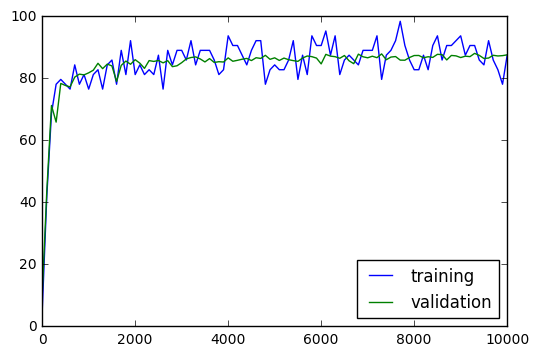

In [16]:
# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# S2: sub-sampling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 6 x 32
# S4: sub-sampling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 128, convolution size: 5 x 5 x 16 x 128
# F6: fully-connected layer, weight size: 128 x 64
# Output layer, weight size: 64 x 10

batch_size = 64
patch_size = 5
num_hidden = 128
num_hidden2 = 64
depth = 32
depth_1 = 64
depth_2 = 64

# batch_size = 128
# patch_size = 3

beta = 0.01
graph_with_3_conv_2_fc = tf.Graph()

def print_matrix_shape(mat, net):
    pass
#     print (net + ":" + str(mat.get_shape().as_list()))
#     print ()
with graph_with_3_conv_2_fc.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  print ( "image_size:" + str(image_size) +  ", num_channels:" + str(num_channels))
  layer1_weights = tf.get_variable('conv1_weights', 
       shape=[patch_size, patch_size, num_channels, depth], 
       initializer=tf.contrib.layers.xavier_initializer())
  layer1_biases = tf.Variable(tf.zeros([depth]))
  print_matrix_shape(layer1_weights, "layer1_weights")
  print_matrix_shape(layer1_biases, "layer1_biases")

  layer2_weights = tf.get_variable('conv2_weights', shape=
      [patch_size, patch_size, depth, depth_1], initializer=tf.contrib.layers.xavier_initializer())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_1]))

  print_matrix_shape(layer2_weights, "layer2_weights")
  print_matrix_shape(layer2_biases, "layer2_biases")

  layer3_weights = tf.get_variable('conv3_weights', shape=
      [patch_size, patch_size, depth_1, depth_2], initializer=tf.contrib.layers.xavier_initializer())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]))

  print_matrix_shape(layer3_weights, "layer3_weights")
  print_matrix_shape(layer3_biases, "layer3_biases")
  
  print ("image_size") 
  print (image_size // 6)
  layer4_weights = tf.get_variable('conv4_weights', shape=
      [(image_size // 6) * (image_size // 6) * depth_2, num_hidden], initializer=tf.contrib.layers.xavier_initializer())
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  
  print_matrix_shape(layer4_weights, "layer4_weights")
  print_matrix_shape(layer4_biases, "layer4_biases")
    
  # FC 1   
  layer5_weights = tf.get_variable('fc1_weights',shape=[num_hidden, num_hidden2], initializer=tf.contrib.layers.xavier_initializer())
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))

  print_matrix_shape(layer5_weights, "layer5_weights")
  print_matrix_shape(layer5_biases, "layer5_biases")
    

  # FC 2   
  layer6_weights = tf.get_variable('fc2_weights', shape=
      [num_hidden2, num_labels], initializer=tf.contrib.layers.xavier_initializer())
  layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  print_matrix_shape(layer6_weights, "layer6_weights")
  print_matrix_shape(layer6_biases, "layer6_biases")
  print ()
    

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    print ("--------------------------------")    
    print_matrix_shape(data, "data")        
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')

    print_matrix_shape(conv, "conv 1")        
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

    print_matrix_shape(pool, "pool 1")        
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    print_matrix_shape(conv, "conv 2")        
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    print_matrix_shape(pool, "pool 2")        

    conv = tf.nn.conv2d(pool, layer3_weights, [1, 1, 1, 1], padding='SAME')
    print_matrix_shape(conv, "conv 3")        
    hidden = tf.nn.relu(conv + layer3_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    print_matrix_shape(pool, "pool 3")        
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    print_matrix_shape(reshape, "reshape 3")        
    print_matrix_shape(layer4_weights, "layer4_weights ")        
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    
    fc_1 = tf.nn.relu(tf.matmul(hidden, layer5_weights) + layer5_biases)
    return tf.matmul(fc_1, layer6_weights) + layer6_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer6_weights) + beta * tf.nn.l2_loss(layer4_weights) + beta * tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))


num_steps = 10001
step_hist = []
train_accs = []
valid_accs = []

learning_rate_start = 0.05
dropout = 0.7

with tf.Session(graph=graph_with_3_conv_2_fc) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 800) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()


# Things to try 

In [ ]:
optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
 # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(0.05).minimize(loss)
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.05, global_step, 2000, 0.95)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
#  optimizer = tf.train.MomentumOptimizer(0.1,0.9).minimize(loss, global_step=global_step)
#  optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
num_hidden1 = 256
num_hidden2 = 128




## 3 Conv, layer, 3 FC layers with patch size(filter size = 3) 

In [19]:

batch_size = 64
patch_size = 3
num_hidden = 128
num_hidden2 = 64
depth = 32
depth_1 = 64
depth_2 = 64

#### Validation accuracy: 85.7%, Test with loss in weights accuracy: 91.3%

## 3 Conv, layer, 3 FC layers. with batch size 128


image_size:28, num_channels:1
image_size
4

--------------------------------
--------------------------------
--------------------------------
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 6.438794
Minibatch accuracy: 14.1%
Validation accuracy: 10.0%
Minibatch loss at step 1500: 1.304661
Minibatch accuracy: 83.6%
Validation accuracy: 82.3%
Minibatch loss at step 3000: 0.866663
Minibatch accuracy: 85.9%
Validation accuracy: 86.0%
Minibatch loss at step 4500: 0.712348
Minibatch accuracy: 84.4%
Validation accuracy: 86.7%
Minibatch loss at step 6000: 0.785249
Minibatch accuracy: 83.6%
Validation accuracy: 86.7%
Minibatch loss at step 7500: 0.555409
Minibatch accuracy: 89.8%
Validation accuracy: 87.3%
Minibatch loss at step 9000: 0.674858
Minibatch accuracy: 85.2%
Validation accuracy: 87.0%
Test with loss in weights accuracy: 92.7%


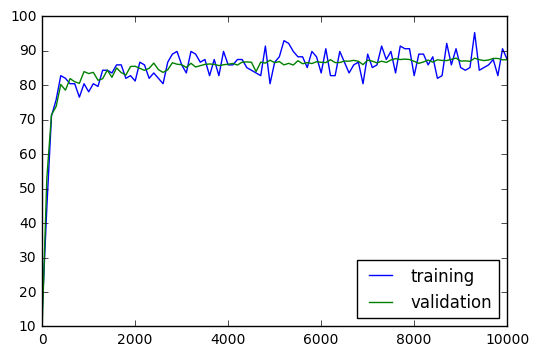

In [21]:
# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# S2: sub-sampling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 6 x 32
# S4: sub-sampling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 128, convolution size: 5 x 5 x 16 x 128
# F6: fully-connected layer, weight size: 128 x 64
# Output layer, weight size: 64 x 10

batch_size = 128
patch_size = 5
num_hidden = 128
num_hidden2 = 64
depth = 32
depth_1 = 64
depth_2 = 64

beta = 0.01
graph_with_3_conv_2_fc = tf.Graph()

def print_matrix_shape(mat, net):
    pass
#     print (net + ":" + str(mat.get_shape().as_list()))
#     print ()
with graph_with_3_conv_2_fc.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  dropout_prob = tf.placeholder("float")
  # Variables.
  print ( "image_size:" + str(image_size) +  ", num_channels:" + str(num_channels))
  layer1_weights = tf.get_variable('conv1_weights', 
       shape=[patch_size, patch_size, num_channels, depth], 
       initializer=tf.contrib.layers.xavier_initializer())
  layer1_biases = tf.Variable(tf.zeros([depth]))
  print_matrix_shape(layer1_weights, "layer1_weights")
  print_matrix_shape(layer1_biases, "layer1_biases")

  layer2_weights = tf.get_variable('conv2_weights', shape=
      [patch_size, patch_size, depth, depth_1], initializer=tf.contrib.layers.xavier_initializer())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_1]))

  print_matrix_shape(layer2_weights, "layer2_weights")
  print_matrix_shape(layer2_biases, "layer2_biases")

  layer3_weights = tf.get_variable('conv3_weights', shape=
      [patch_size, patch_size, depth_1, depth_2], initializer=tf.contrib.layers.xavier_initializer())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]))

  print_matrix_shape(layer3_weights, "layer3_weights")
  print_matrix_shape(layer3_biases, "layer3_biases")
  
  print ("image_size") 
  print (image_size // 6)
  layer4_weights = tf.get_variable('conv4_weights', shape=
      [(image_size // 6) * (image_size // 6) * depth_2, num_hidden], initializer=tf.contrib.layers.xavier_initializer())
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  
  print_matrix_shape(layer4_weights, "layer4_weights")
  print_matrix_shape(layer4_biases, "layer4_biases")
    
  # FC 1   
  layer5_weights = tf.get_variable('fc1_weights',shape=[num_hidden, num_hidden2], initializer=tf.contrib.layers.xavier_initializer())
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))

  print_matrix_shape(layer5_weights, "layer5_weights")
  print_matrix_shape(layer5_biases, "layer5_biases")
    

  # FC 2   
  layer6_weights = tf.get_variable('fc2_weights', shape=
      [num_hidden2, num_labels], initializer=tf.contrib.layers.xavier_initializer())
  layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  print_matrix_shape(layer6_weights, "layer6_weights")
  print_matrix_shape(layer6_biases, "layer6_biases")
  print ()
    

# Model.
  def model_with_max_pool_and_drop_out(data, dropout):
    print ("--------------------------------")    
    print_matrix_shape(data, "data")        
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')

    print_matrix_shape(conv, "conv 1")        
    hidden = tf.nn.relu(conv + layer1_biases)
    if dropout != 0.0:
      hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

    print_matrix_shape(pool, "pool 1")        
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    print_matrix_shape(conv, "conv 2")        
    hidden = tf.nn.relu(conv + layer2_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    print_matrix_shape(pool, "pool 2")        

    conv = tf.nn.conv2d(pool, layer3_weights, [1, 1, 1, 1], padding='SAME')
    print_matrix_shape(conv, "conv 3")        
    hidden = tf.nn.relu(conv + layer3_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    print_matrix_shape(pool, "pool 3")        
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    print_matrix_shape(reshape, "reshape 3")        
    print_matrix_shape(layer4_weights, "layer4_weights ")        
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    if dropout != 0.0:
       hidden = tf.nn.dropout(hidden, dropout)        
    
    fc_1 = tf.nn.relu(tf.matmul(hidden, layer5_weights) + layer5_biases)
    return tf.matmul(fc_1, layer6_weights) + layer6_biases


  # Training computation.
  logits = model_with_max_pool_and_drop_out(tf_train_dataset, dropout_prob)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + beta * tf.nn.l2_loss(layer1_weights) + beta * tf.nn.l2_loss(layer2_weights) + beta *tf.nn.l2_loss(layer3_weights)
        + beta * tf.nn.l2_loss(layer6_weights) + beta * tf.nn.l2_loss(layer4_weights) + beta * tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_r = tf.placeholder("float")
  learning_rate = tf.train.exponential_decay(learning_r, global_step, 700, 0.90)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_valid_dataset, 0.0))
  test_prediction = tf.nn.softmax(model_with_max_pool_and_drop_out(tf_test_dataset, 0.0))


num_steps = 10001
step_hist = []
train_accs = []
valid_accs = []

learning_rate_start = 0.05
dropout = 0.7

with tf.Session(graph=graph_with_3_conv_2_fc) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                dropout_prob: dropout, learning_r: learning_rate_start}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_hist.append(step) 
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      train_accs.append(train_acc)
      valid_accs.append(val_acc)
      if (step % 1500) == 0:
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % train_acc)
          print('Validation accuracy: %.1f%%' % val_acc)
  print('Test with loss in weights accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
plt.plot(step_hist, train_accs, 'b', label='training')
plt.plot(step_hist, valid_accs, 'g', label='validation')
plt.legend(loc="lower right")
plt.show()
